# Evaluate Meta-Model per Drift Class
### Before fine-tune and after fine-tune!

In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from mlxtend.plotting import plot_confusion_matrix
from utils.evalUtils import calc_cm_metrics
from utils.evalUtils import print_confusion_matrix

import joblib

In [2]:
%run -i ./scripts/PythonImports.py

Imports..


In [3]:
## Set Configs
print('Set configs..')
sns.set()
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')
RANDOM_SEED = 42

fig_path = os.path.join(os.getcwd(), 'figs')
model_path = os.path.join(os.getcwd(), 'models')
model_bib_path = os.path.join(model_path,'model_bib')
data_path = os.path.join(os.getcwd(), 'data')

Set configs..


## Read Meta-Model

In [4]:
%run -i ./scripts/ReadSimpleAE_w_weights.py

Load trained simple AE..
/home/torge/dev/masterthesis_code/02_Experimente/AnomalyDetection/models/model_bib/20200302_firstAE_model.pt
SimpleAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=17, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=8, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=17, bias=True)
    (3): Tanh()
  )
)
Load weights..


In [5]:
type(model)

models.SimpleAutoEncoder.SimpleAutoEncoder

## Read LogReg

In [7]:
%run -i ./scripts/ReadLogReg.py

Load trained LogReg..
LogisticRegression(C=1.0, class_weight={1: 2.0}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [8]:
type(clf)

sklearn.linear_model._logistic.LogisticRegression

## Prepare the data

In [9]:
data_fn = os.path.join(data_path, 'simulation_data_y_2020_2021_reduced.h5')
df_data_train = pd.read_hdf(data_fn, key='df')
print('Shape of X_train data: {}'.format(df_data_train.shape))

Shape of X_train data: (105216, 17)


In [10]:
data_fn = os.path.join(data_path, 'anomalous_drifted_data_y_2023_reduced_more_cos_phi.h5')
df_data_drifted_ano = pd.read_hdf(data_fn, key='df')
print('Shape of X_drifted,ano data: {}'.format(df_data_drifted_ano.shape))

Shape of X_drifted,ano data: (35040, 19)


In [11]:
s_drift_labels = df_data_drifted_ano['drift_labels']
s_drift_labels.reset_index(inplace=True, drop=True)
s_ano_labels = df_data_drifted_ano['anomaly_labels']
s_ano_labels.reset_index(inplace=True, drop=True)

In [12]:
df_data_drifted_ano.drop('drift_labels', axis=1, inplace=True)
df_data_drifted_ano.drop('anomaly_labels', axis=1, inplace=True)
print('Shape of X_drifted,ano data: {}'.format(df_data_drifted_ano.shape))

Shape of X_drifted,ano data: (35040, 17)


In [13]:
print('Scale data..')
scaler_train = MinMaxScaler((-1,1))
scaler_train = scaler_train.fit(df_data_train)
scaled_drifted_ano = scaler_train.transform(df_data_drifted_ano.to_numpy())

Scale data..


In [14]:
del(df_data_train)

In [15]:
# build tensor from numpy
anormal_drifted_torch_tensor = torch.from_numpy(scaled_drifted_ano).type(torch.FloatTensor)

## Make Predictions vor evaluation

In [16]:
re_drifted_ano = []
for val in anormal_drifted_torch_tensor:
    loss = model.calc_reconstruction_error(val)
    re_drifted_ano.append(loss.item())
    
s_re_drifted_ano = pd.Series(re_drifted_ano)

In [17]:
s_re_drifted_ano = s_re_drifted_ano.values.reshape(-1,1)

In [18]:
predictions_drifted_ano = []
for val in s_re_drifted_ano:
    val = val.reshape(1,-1)
    pred = clf.predict(val)
    predictions_drifted_ano.append(pred[0])

## Build dataset for analysis

In [19]:
df_analyze = pd.DataFrame()

In [20]:
df_analyze['anomaly_labels'] = s_ano_labels
df_analyze['drift_labels'] = s_drift_labels
df_analyze['reconstruction_error'] = s_re_drifted_ano
df_analyze['ano_prediction'] = predictions_drifted_ano

In [21]:
df_analyze.head()

,anomaly_labels,drift_labels,reconstruction_error,ano_prediction
0,0.0,0.0,0.000535,0
1,0.0,0.0,0.000788,0
2,0.0,0.0,0.001352,0
3,2.0,0.0,0.055268,0
4,2.0,0.0,0.054615,0


## Split Dataset per Drift Class

In [22]:
df_drift_class_0 = df_analyze[df_analyze['drift_labels'] == 0]
df_drift_class_1 = df_analyze[df_analyze['drift_labels'] == 1]
df_drift_class_2 = df_analyze[df_analyze['drift_labels'] == 2]
df_drift_class_3 = df_analyze[df_analyze['drift_labels'] == 3]

In [23]:
df_drift_class_0['reduced_ano_labels'] = [1 if x > 0 else 0 for x in df_drift_class_0['anomaly_labels']]
df_drift_class_1['reduced_ano_labels'] = [1 if x > 0 else 0 for x in df_drift_class_1['anomaly_labels']]
df_drift_class_2['reduced_ano_labels'] = [1 if x > 0 else 0 for x in df_drift_class_2['anomaly_labels']]
df_drift_class_3['reduced_ano_labels'] = [1 if x > 0 else 0 for x in df_drift_class_3['anomaly_labels']]

In [44]:
df_drift_class_3['reduced_ano_labels'].sum()

360

In [24]:
df_drift_class_0.describe()

,anomaly_labels,drift_labels,reconstruction_error,ano_prediction,reduced_ano_labels
count,1112.000000,1112.0,1112.000000,1112.000000,1112.000000
mean,0.054856,0.0,0.003973,0.008094,0.023381
std,0.364557,0.0,0.026174,0.089640,0.151179
min,0.000000,0.0,0.000071,0.000000,0.000000
25%,0.000000,0.0,0.000424,0.000000,0.000000
50%,0.000000,0.0,0.000746,0.000000,0.000000
75%,0.000000,0.0,0.001252,0.000000,0.000000
max,3.000000,0.0,0.538637,1.000000,1.000000


In [25]:
df_drift_class_1.describe()

,anomaly_labels,drift_labels,reconstruction_error,ano_prediction,reduced_ano_labels
count,3132.000000,3132.0,3.132000e+03,3132.0,3132.000000
mean,0.009898,1.0,3.931895e+06,1.0,0.003512
std,0.170195,0.0,3.288909e+07,0.0,0.059169
min,0.000000,1.0,1.031072e+04,1.0,0.000000
25%,0.000000,1.0,3.392249e+04,1.0,0.000000
50%,0.000000,1.0,1.118555e+05,1.0,0.000000
75%,0.000000,1.0,1.472867e+05,1.0,0.000000
max,3.000000,1.0,4.243649e+08,1.0,1.000000


In [26]:
df_drift_class_2.describe()

,anomaly_labels,drift_labels,reconstruction_error,ano_prediction,reduced_ano_labels
count,17855.000000,17855.0,17855.000000,17855.000000,17855.000000
mean,0.234836,2.0,1171.192880,0.127583,0.117614
std,0.643897,0.0,13867.366287,0.333635,0.322160
min,0.000000,2.0,0.000019,0.000000,0.000000
25%,0.000000,2.0,0.000271,0.000000,0.000000
50%,0.000000,2.0,0.000649,0.000000,0.000000
75%,0.000000,2.0,0.001839,0.000000,0.000000
max,3.000000,2.0,270386.750000,1.000000,1.000000


In [27]:
df_drift_class_3.describe()

,anomaly_labels,drift_labels,reconstruction_error,ano_prediction,reduced_ano_labels
count,12941.000000,12941.0,12941.000000,12941.000000,12941.000000
mean,0.056642,3.0,0.037671,0.022950,0.027819
std,0.337904,0.0,0.263652,0.149751,0.164459
min,0.000000,3.0,0.000044,0.000000,0.000000
25%,0.000000,3.0,0.000439,0.000000,0.000000
50%,0.000000,3.0,0.000841,0.000000,0.000000
75%,0.000000,3.0,0.001509,0.000000,0.000000
max,3.000000,3.0,2.145881,1.000000,1.000000


## KPIs per Drift Class

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from mlxtend.plotting import plot_confusion_matrix
from utils.evalUtils import calc_cm_metrics

In [29]:
cm_dc_0 = confusion_matrix(df_drift_class_0['reduced_ano_labels'], df_drift_class_0['ano_prediction'])
tn, fp, fn, tp  = cm_dc_0.ravel()

In [30]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 98.47122302069721
Precision: 99.99999988888888
Specifity: 99.17808219087509
Sensitivity: 34.615384602071
F1-Score: 51.428571413877556


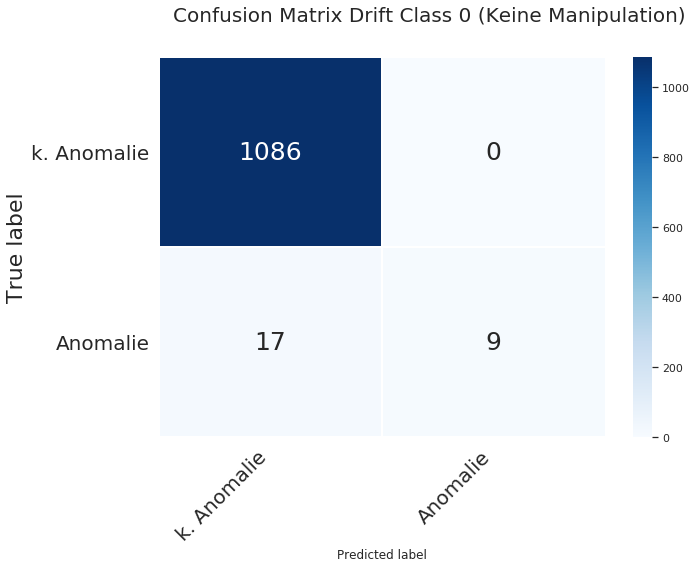

In [31]:
fig = print_confusion_matrix(cm_dc_0, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix Drift Class 0 (Keine Manipulation)', fontsize=20)
file_n = os.path.join(fig_path, 'cm_drift_class_0.pdf')
fig.savefig(file_n, bbox_inches = 'tight', pad_inches = 0 )

In [32]:
cm_dc_1 = confusion_matrix(df_drift_class_1['reduced_ano_labels'], df_drift_class_1['ano_prediction'])
tn, fp, fn, tp  = cm_dc_1.ravel()

In [33]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 0.3512132822466436
Precision: 0.3512132822466436
Specifity: 0.0
Sensitivity: 99.9999999090909
F1-Score: 0.69996818326217


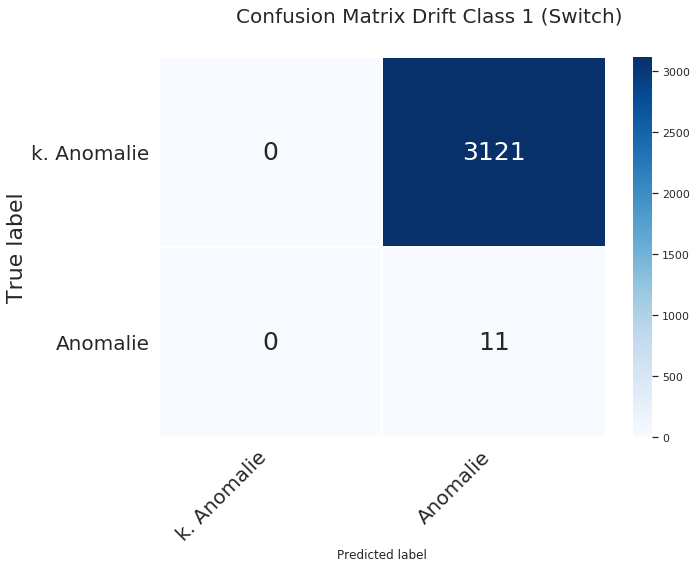

In [34]:
fig = print_confusion_matrix(cm_dc_1, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix Drift Class 1 (Switch)', fontsize=20)
file_n = os.path.join(fig_path, 'meta_modell_cm_drift_class_1.pdf')
fig.savefig(file_n, bbox_inches = 'tight', pad_inches = 0 )

In [35]:
cm_dc_2 = confusion_matrix(df_drift_class_2['reduced_ano_labels'], df_drift_class_2['ano_prediction'])
tn, fp, fn, tp  = cm_dc_2.ravel()

In [36]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 98.8462615513308
Precision: 91.57155399433024
Specifity: 88.18063346360236
Sensitivity: 99.33333333286032
F1-Score: 95.2946550934324


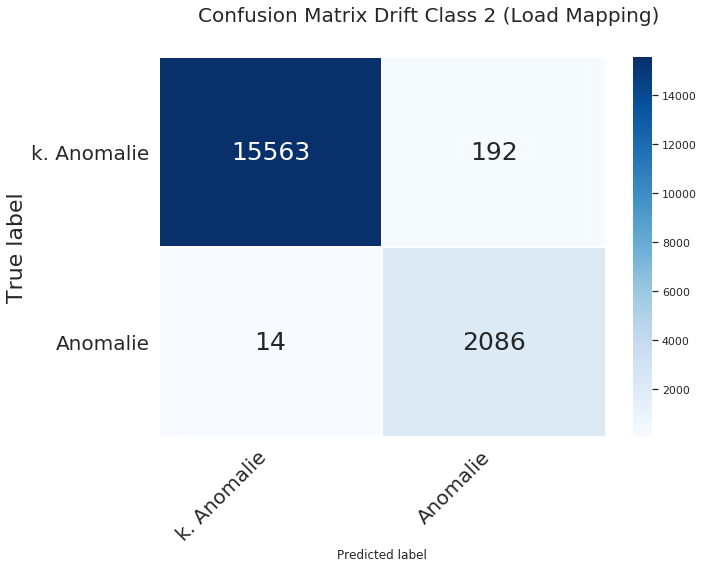

In [37]:
fig = print_confusion_matrix(cm_dc_2, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix Drift Class 2 (Load Mapping)', fontsize=20)
file_n = os.path.join(fig_path, 'meta_modell_cm_drift_class_2.pdf')
fig.savefig(file_n, bbox_inches = 'tight', pad_inches = 0 )

In [38]:
cm_dc_3 = confusion_matrix(df_drift_class_3['reduced_ano_labels'], df_drift_class_3['ano_prediction'])
tn, fp, fn, tp  = cm_dc_3.ravel()

In [39]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 99.51317517958464
Precision: 99.999999996633
Specifity: 97.69374126409559
Sensitivity: 82.49999999770833
F1-Score: 90.41095890273347


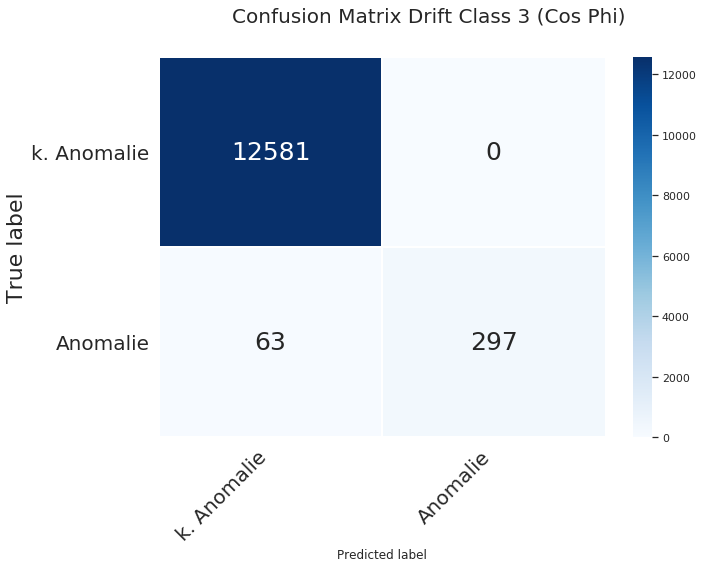

In [40]:
fig = print_confusion_matrix(cm_dc_3, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix Drift Class 3 (Cos Phi)', fontsize=20)
file_n = os.path.join(fig_path, 'meta_modell_cm_drift_class_3.pdf')
fig.savefig(file_n, bbox_inches = 'tight', pad_inches = 0 )